In [6]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
test_file = '/home/sbozonnet/SRC/ecm_ocr_preprocessing/data/samples/{CA7F4B01-EC83-44E4-9285-964CBC68357E}.pdf-0.png'

In [8]:
# from skimage import io
import numpy as np
import cv2


def pixel_max(fft_img):
    """
    Return position (i,j) of pixel with the maximum of 2D-FFT
    :param fft_img: 
    :return: 
    """
    # if the shape of the array is (n,m)
    # then idx of pixel (i,j) is given by idx = i*m + j
    idx = np.argmax(fft_img) # index of max value => i * m + j
    i = idx // fft_img.shape[1]  # since j < m
    j = idx - fft_img.shape[1] * i
    return i, j


def angular_hough_line_transform(img, center, radius, n_radius, n_theta=181):
    """
    Test direction from -pi/2 to pi/2 with radius r in [1, n_radius]
    :param img:
    :param center:
    :param radius:
    :param n_radius:
    :param n_theta:
    :return:
    """
    n = 4
    theta = np.linspace(-np.pi / n, np.pi / n, n_theta)
    radius_array = np.linspace(1, radius, n_radius)
    accumulator = np.zeros(n_theta)
    for i_theta in range(n_theta):
        cos = np.cos(theta[i_theta])
        sin = np.sin(theta[i_theta])
        cos90 = np.cos(theta[i_theta] + np.pi / 2)
        sin90 = np.sin(theta[i_theta] + np.pi / 2)
        lc = list(np.round(radius_array * cos) + center[0])
        ls = list(np.round(radius_array * sin) + center[1])
        lc90 = list(np.round(radius_array * cos90) + center[0])
        ls90 = list(np.round(radius_array * sin90) + center[1])
        v = zip(lc, ls)
        v90 = zip(lc90, ls90)
        accumulator[i_theta] = (np.sum(np.array([img[int(idx[0]), int(idx[1])] for idx in v]))
                                + np.sum(np.array([img[int(idx[0]), int(idx[1])] for idx in v90])))
    return accumulator, theta + np.pi / 2


def rotation_normalization(img):
    """
    Rotation normalization : provide the picture of a constat as a numpy array, and obtain the derotated image and the angle in degrees. This method works for small image rotations.
    :param img:
    :return: numpy array representing the picture and theta : the estimated rotation angle of the rotation applied to the image, in degrees
    """
    d2_img = cv2.Laplacian(img, cv2.CV_64F)
    d2_img_nb = np.sum(d2_img, 2)  # sum up by channel (RGB)
    
    # normalize laplacian:
    d2_img_nb_scale = np.abs(d2_img_nb)
    d2_img_nb_scale = d2_img_nb_scale / np.max(d2_img_nb_scale)

    # apodization window
    w0 = np.sin(np.linspace(0, np.pi, d2_img_nb_scale.shape[0])) ** 2
    w1 = np.sin(np.linspace(0, np.pi, d2_img_nb_scale.shape[1])) ** 2
    w0 = w0.reshape(len(w0), 1)
    w1 = w1.reshape(1, len(w1))
    w_apo = w0 * w1

    # compute FFT:
    fft_img = np.abs(np.fft.fft2(d2_img_nb_scale * w_apo))
    fft_img = np.fft.fftshift(fft_img / np.max(fft_img))
    
    # get center of the maximum:
    center = pixel_max(fft_img)
    radius = min(fft_img.shape) // 8
    n_radius = min(fft_img.shape) // 8

    # detect angle of rotation
    a, t = angular_hough_line_transform(fft_img, center, radius, n_radius, n_theta=180 * 4 + 1)
    theta_max_deg = t[np.argmax(a)] * 180 / np.pi
    theta_rotate_deg = 90 - theta_max_deg

    # derotate image
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), theta_rotate_deg, 1)
    derotated_img = cv2.warpAffine(img, M, (cols, rows))
    return derotated_img, theta_rotate_deg


In [10]:
# read a test file:
img_org = cv2.imread(test_file)

img_org= (987, 1301, 3)
d2_img= (987, 1301, 3)
d2_img_nb= (987, 1301)
d2_img_nb_scale= (987, 1301)
1243.0
w_apo= (987, 1301)
center= (493, 650)
radius= 123
n_radius= 123


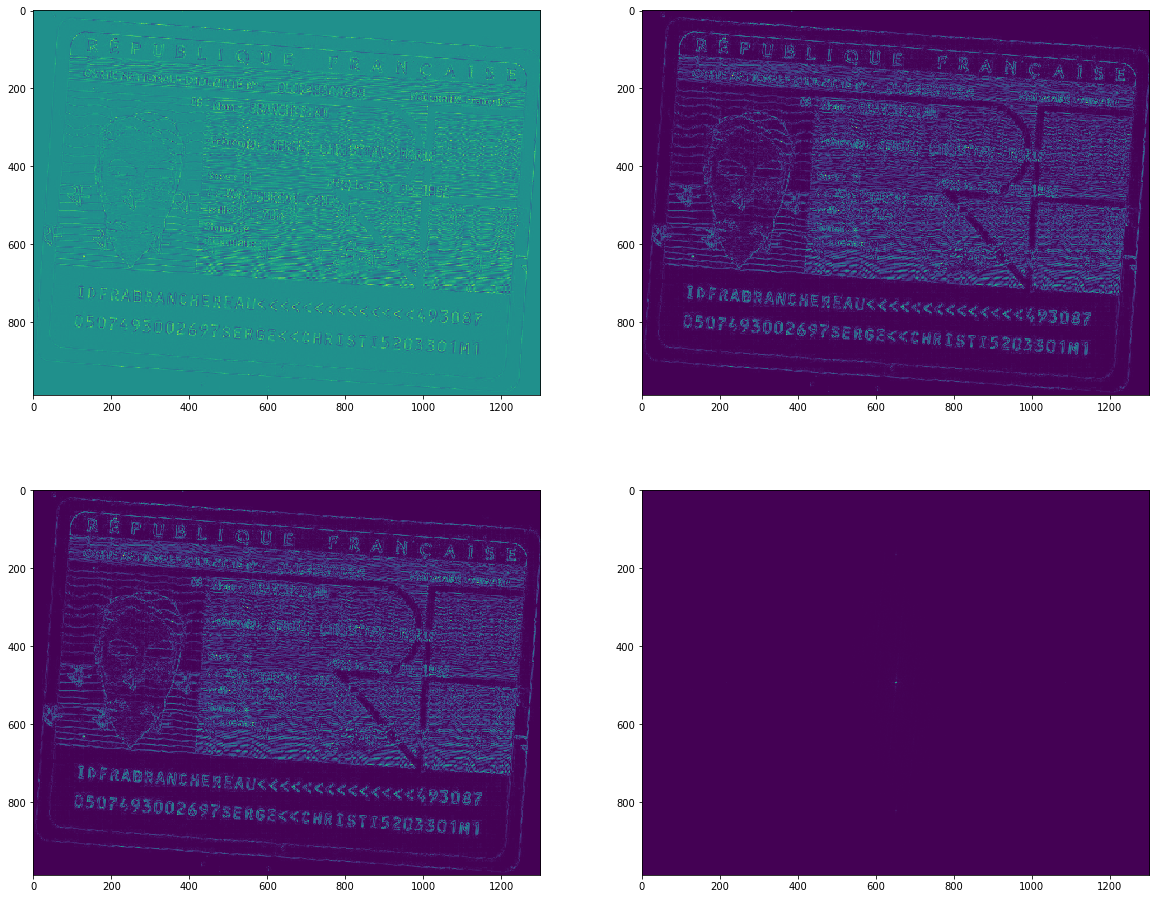

In [11]:
fig1 = plt.figure(figsize=(20, 25))

print "img_org=", img_org.shape
d2_img = cv2.Laplacian(img_org, cv2.CV_64F)
print "d2_img=", d2_img.shape
d2_img_nb = np.sum(d2_img, 2)

ax1 = fig1.add_subplot(321)
ax1.imshow(d2_img_nb)

print "d2_img_nb=", d2_img_nb.shape
d2_img_nb_scale = np.abs(d2_img_nb)
print "d2_img_nb_scale=", d2_img_nb_scale.shape

ax2 = fig1.add_subplot(322)
ax2.imshow(d2_img_nb_scale)

# normalize:
print np.max(d2_img_nb_scale)
d2_img_nb_scale = d2_img_nb_scale / np.max(d2_img_nb_scale)
#plt.imshow(d2_img_nb_scale)

ax3 = fig1.add_subplot(323)
ax3.imshow(d2_img_nb_scale)

# apodization window for FFT windowing
w0 = np.sin(np.linspace(0, np.pi, d2_img_nb_scale.shape[0])) ** 2
w1 = np.sin(np.linspace(0, np.pi, d2_img_nb_scale.shape[1])) ** 2
w0 = w0.reshape(len(w0), 1)
w1 = w1.reshape(1, len(w1))
w_apo = w0 * w1
print "w_apo=", w_apo.shape

# compute FFT:
fft_img = np.abs(np.fft.fft2(d2_img_nb_scale * w_apo))
fft_img = np.fft.fftshift(fft_img / np.max(fft_img)) # and normalize the norm FFT

ax3 = fig1.add_subplot(324)
ax3.imshow(fft_img)

# get center of the maximum:
center = pixel_max(fft_img)
print "center=", center
radius = min(fft_img.shape) // 8
print "radius=", radius
n_radius = min(fft_img.shape) // 8
print "n_radius=", n_radius

# detect angle of rotation
a, t = angular_hough_line_transform(fft_img, center, radius, n_radius, n_theta=180 * 4 + 1)
theta_max_deg = t[np.argmax(a)] * 180 / np.pi
theta_rotate_deg = 90 - theta_max_deg

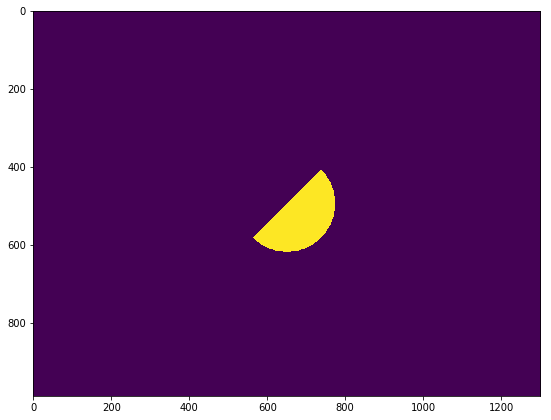

In [14]:
# illustrate zone of the FFT analysis:
img = fft_img
theta = np.linspace(-np.pi / 4, np.pi / 4, n_theta)
radius_array = np.linspace(1, radius, n_radius)
accumulator = np.zeros(n_theta)
for i_theta in range(n_theta):
    cos = np.cos(theta[i_theta])
    sin = np.sin(theta[i_theta])
    cos90 = np.cos(theta[i_theta] + np.pi / 2)
    sin90 = np.sin(theta[i_theta] + np.pi / 2)
    lc = list(np.round(radius_array * cos) + center[0])
    ls = list(np.round(radius_array * sin) + center[1])
    lc90 = list(np.round(radius_array * cos90) + center[0])
    ls90 = list(np.round(radius_array * sin90) + center[1])
    v = zip(lc, ls)
    v90 = zip(lc90, ls90)
    for idx in v:
        img[int(idx[0]), int(idx[1])] = 255
    for idx in v90:            
        img[int(idx[0]), int(idx[1])] = 255
        
fig1 = plt.figure(figsize=(20, 25))
ax1 = fig1.add_subplot(321)
ax1.imshow(img)

angle= 5.125


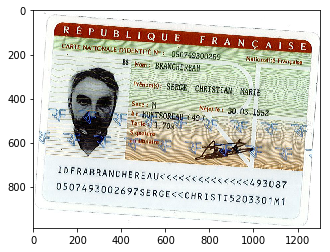

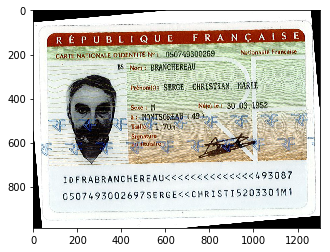

In [15]:
f1 = plt.imshow(img_org)
[derotated_img, theta_rotate_deg] = rotation_normalization(img_org)
print 'angle=', theta_rotate_deg
plt.figure()
f2 = plt.imshow(derotated_img)